In [69]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [70]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS=40

In [71]:
print(IMAGE_SIZE)

256


In [114]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "LeafImage", shuffle=True, image_size = (IMAGE_SIZE,IMAGE_SIZE), batch_size = BATCH_SIZE
)

Found 639 files belonging to 5 classes.


In [115]:
class_names = dataset.class_names

In [116]:
class_names

['Aloe_Vera',
 'Amaranthus_Viridis_(Arive-Dantu)',
 'Basella_Alba_(Basale)',
 'Ficus_Religiosa_(Peepal_Tree)',
 'Mentha_(Mint)']

(32, 256, 256, 3)
[4 4 4 3 0 0 4 2 3 3 2 4 3 4 3 4 3 1 4 4 4 4 4 4 4 4 3 4 4 0 1 3]


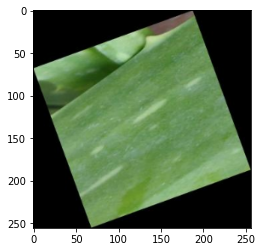

In [75]:
for i,j in dataset.take(1):
    plt.imshow(i[0].numpy().astype("uint8")) #to print the image. first they were in float so we converted it to int using .astype("uint8")
    print(i.shape) #it shows batch_size,height,width,rgb channel(3 represents rgb)
    print(j.numpy()) #this prints the class of one batch 0 1 or 2

In [76]:
print(len(dataset))

20


In [77]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12) #shuffling
    
    train_size = int(train_split*ds_size) #finding 80% of len of ds for training
    val_size = int(val_split*ds_size)     #finding 20% of len of ds for validating(test)
    
    train_ds = ds.take(train_size)       #storing that first 80% of data into train_ds

    val_ds = ds.skip(train_size).take(val_size)   #skipping first 80 and storing next 10% in val_ds
    
    test_size = int(test_split*ds_size)    #10% size of ds

    test_ds = ds.skip(train_size+val_size).take(test_size)   #storing last 10% of data for testing

    return train_ds,val_ds,test_ds

In [78]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [79]:
print(len(dataset))
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

20
16
2
2


In [80]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [81]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [82]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), 
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [83]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 5
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)), 
    
    layers.Conv2D(64, kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)), 
    
    layers.Conv2D(64, (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)), 
    
    layers.Conv2D(64, (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)), 
    
    layers.Conv2D(64, (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)), 
    
    layers.Flatten(),
    
    layers.Dense(64,activation='relu'),
    
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

In [84]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [85]:
history = model.fit( 
    train_ds, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    verbose=1, 
    validation_data=val_ds )

Epoch 1/40
16/16 [==============================] - 33s 2s/step - loss: 1.4073 - accuracy: 0.4834 - val_loss: 0.9423 - val_accuracy: 0.5938
Epoch 2/40
16/16 [==============================] - 26s 2s/step - loss: 0.7564 - accuracy: 0.6908 - val_loss: 0.7447 - val_accuracy: 0.6562
Epoch 3/40
16/16 [==============================] - 26s 2s/step - loss: 0.7259 - accuracy: 0.6810 - val_loss: 0.5953 - val_accuracy: 0.7812
Epoch 4/40
16/16 [==============================] - 26s 2s/step - loss: 0.5703 - accuracy: 0.7554 - val_loss: 0.3732 - val_accuracy: 0.8438
Epoch 5/40
16/16 [==============================] - 26s 2s/step - loss: 0.4502 - accuracy: 0.8063 - val_loss: 0.6656 - val_accuracy: 0.7500
Epoch 6/40
16/16 [==============================] - 26s 2s/step - loss: 0.3509 - accuracy: 0.8689 - val_loss: 0.2176 - val_accuracy: 0.9219
Epoch 7/40
16/16 [==============================] - 26s 2s/step - loss: 0.2331 - accuracy: 0.9041 - val_loss: 0.1453 - val_accuracy: 0.9531
Epoch 8/40
16/16 [==

In [86]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 3s 500ms/step - loss: 0.0343 - accuracy: 0.9841


In [87]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


Text(0.5, 1.0, 'Training and Validation Accuracy')

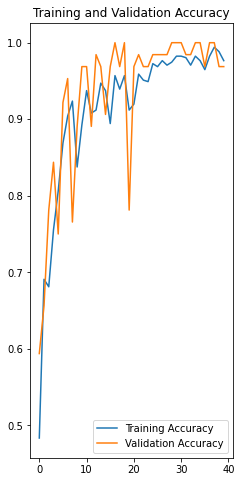

In [89]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Actual label:  Mentha_(Mint)
Predicted label:  Mentha_(Mint)


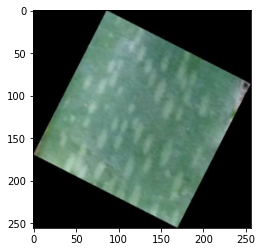

In [118]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    plt.imshow(first_image)
    print("Actual label: ",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [111]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

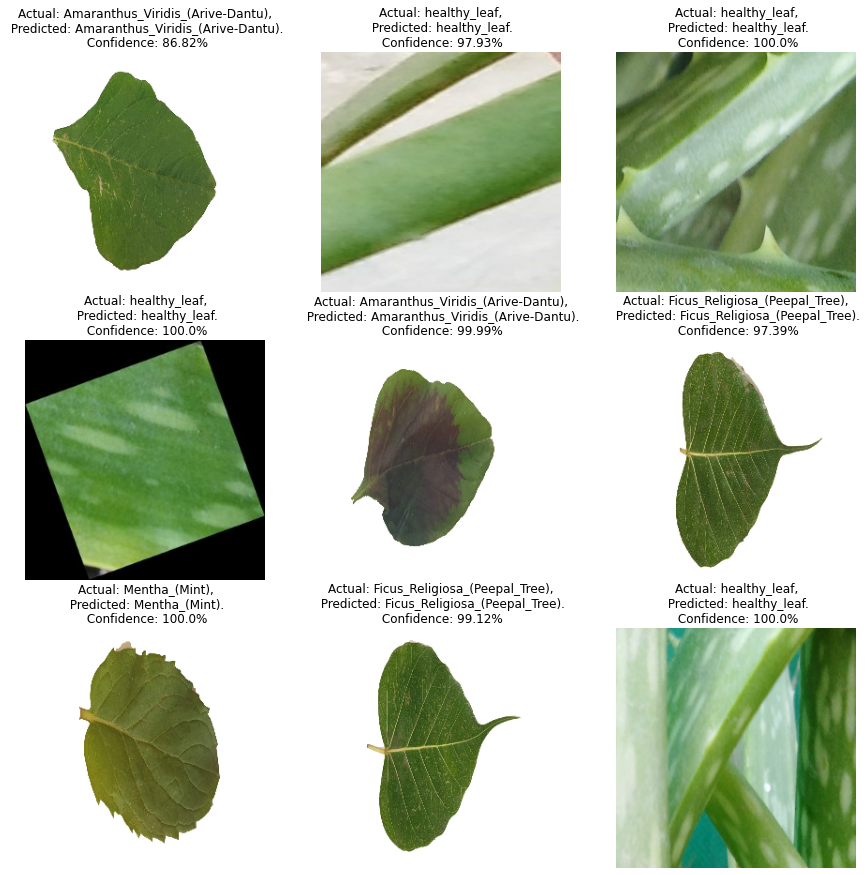

In [105]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [103]:
mversion = 1
model.save(f"../models/{mversion}")

INFO:tensorflow:Assets written to: ../models/1\assets


In [106]:
import cv2

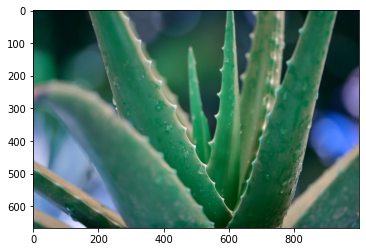

In [107]:
img = cv2.imread('aloetest.jpg')
plt.imshow(img)
plt.show()

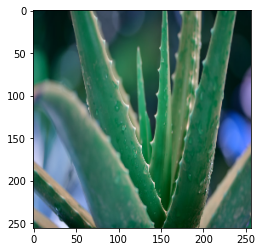

In [108]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [109]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [110]:
yhat

array([[2.9965511e-22, 1.8108961e-24, 9.9990284e-27, 1.8343542e-09,
        1.0000000e+00]], dtype=float32)

In [112]:
print("Predicted label: ", class_names[np.argmax(yhat)])

Predicted label:  healthy_leaf
